# Mouse Aging 10X RNA-seq gene expression  

In this notebook we'll explore some gene expressions and combine them with the cell metadata we showed in the clustering analysis tutorial.

You need to be either connected to the internet or connected to a cache that has the Aging data downloaded already and have already downloaded the example data via the getting started notebook to run this notebook. 

In [41]:
import pandas as pd
import numpy as np
import anndata
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from typing import Optional, Tuple

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

pd.set_option('display.max_columns', 500)

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you have downloaded the data in your system.** 

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241115/manifest.json'

In [3]:
metadata_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-10Xv3/20241130"
)
taxonomy_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-WMB-taxonomy/20241130"
)

Create the expanded cell metadata as was done previously in the cluster annotation tutorial [LINK TO PREVIOUS]. 

In [4]:
# Load the cell metadata.
cell = pd.read_csv(metadata_base / 'cell_metadata.csv', dtype={'cell_label': str,
                                                               'wmb_cluster_alias': 'Int64'})
# cell = abc_cache.get_metadata_dataframe(
#    directory='WHB-10Xv3',
#     file_name='cell_metadata',
#     dtype={'cell_label': str,
#            'wmb_cluster_alias': 'Int64'}
# )
cell.set_index('cell_label', inplace=True)

cell_colors = pd.read_csv(
    metadata_base / 'cell_annotation_colors.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

cluster_mapping = pd.read_csv(
    taxonomy_base / 'cell_cluster_mapping_annotations.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

cluster_info = pd.read_csv(
    metadata_base / 'cluster.csv'
).set_index('cluster_alias')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

# Join on the cell_label index.
cell_extended = cell.join(cluster_mapping, rsuffix='_cl_map')
cell_extended = cell_extended.join(cell_colors, rsuffix='_cl_colors')
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell_extended.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')

# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

# The dataset is sorted on cell_label by default, this causes some plotting weirdness
# due to all "adult" cells being first in the order. Below we scrabble the DataFrame
# to better reproduce plots from the paper.
cell_extended = cell_extended.sample(frac=1, random_state=12345)

del cell
del cell_colors
del cluster_mapping
del cluster_info

cell_extended.head()

,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,alignment_job_id,library_method,barcoded_cell_sample_label,enrichment_population,region_of_interest_label,anatomical_division_label,library_in_wmb_study,donor_label,population_sampling,donor_genotype,donor_sex,donor_age,donor_age_category,donor_in_wmb_study,feature_matrix_label,dataset_label,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color,anatomical_division_color,anatomical_division_order,donor_age_category_color,donor_age_category_order,donor_sex_color,donor_sex_order,region_of_interest_color,region_of_interest_order,number_of_cells,number_of_adult_cells,number_of_aged_cells,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color
cell_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCTGTCGAGGGACACT-149_C01,TCTGTCGAGGGACACT,7999,38882,0.121951,-5.924914,14.984385,653,True,3017,L8TX_190822_01_A11,1178165474,10Xv3,149_C01,"RFP-positive, DAPI-negative",MB - PAG-RAmb,MB,True,Snap25-IRES2-Cre;Ai14-482568,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P56,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0653,652,653_LDT-PCG Vsx2 Lhx4 Glut_4,#f4d883,23 P Glut,221 LDT-PCG Vsx2 Lhx4 Glut,0909 LDT-PCG Vsx2 Lhx4 Glut_4,#6b5ca5,#FF4DC7,#00CC60,#FF64FF,5,#9ACA3C,0,#FAAA5B,0,#FF90FF,12,368,270,98,0.733696,0.266304,0.394921,-1.340363,unassigned,#DADEDF,Glut,Glut,#2B93DF
AAGAACAGTGCAACAG-376_D05,AAGAACAGTGCAACAG,3394,7929,0.100000,6.513575,12.252954,782,False,<NA>,L8TX_201001_01_C08,1177696107,10Xv3,376_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464758,unbiased,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P542,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0782,781,782_Astro-NT NN_2,#7dc53b,30 Astro-Epen,318 Astro-NT NN,1160 Astro-NT NN_2,#594a26,#AD5CCC,#1F8ECC,#FF64FF,5,#CC6828,1,#FAAA5B,0,#FF90FF,12,114479,43800,70679,0.382603,0.617397,0.901961,-0.148863,unassigned,#DADEDF,No-NT,No-NT,#666666
GGAACCCAGCTAGTTC-384_D05,GGAACCCAGCTAGTTC,5023,17205,0.080000,-13.623771,12.990168,768,False,<NA>,L8TX_201009_01_B01,1177696262,10Xv3,384_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464755,unbiased,Ai14(RCL-tdT)/wt,M,P549,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0768,767,768_DTN-LDT-IPN Otp Pax3 Gaba_2,#10bcba,26 P GABA,277 DTN-LDT-IPN Otp Pax3 Gaba,1070 DTN-LDT-IPN Otp Pax3 Gaba_2,#72195a,#1F3766,#459999,#FF64FF,5,#CC6828,1,#735AA6,1,#FF90FF,12,415,246,169,0.592771,0.407229,0.665383,-0.587744,unassigned,#DADEDF,GABA,GABA,#FF3358
AAAGGTAGTTCACCGG-407_B02,AAAGGTAGTTCACCGG,3087,8554,0.000000,13.269343,0.800345,817,True,5231,L8TX_201029_01_B10,1177903593,10Xv3,407_B02,No FACS,HPF - PAR-POST-PRE-SUB-ProS,HPF,True,Snap25-IRES2-Cre;Ai14-549928,unbiased,Ai14(RCL-tdT)/wt,M,P58,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0817,816,817_MOL NN_4,#d87c9f,31 OPC-Oligo,327 Oligo NN,1184 MOL NN_4,#03045E,#99FFBC,#99CAFF,#7ED04B,1,#9ACA3C,0,#735AA6,1,#72D569,6,118842,54013,64829,0.454494,0.545506,1.046448,0.065500,unassigned,#DADEDF,No-NT,No-NT,#666666
ACATCGATCATGGATC-134_A01,ACATCGATCATGGATC,4509,20201,0.020000,0.676959,2.628165,270,True,1070,L8TX_190716_01_H07,1178165212,10Xv3,134_A01,"RFP-positive, DAPI-negative",STR - STRv,STR,True,Snap25-IRES2-Cre;Ai14-469515,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,P64,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0270,269,270_STR D1 Gaba_2,#eba384,09 CNU-LGE GABA,061 STR D1 Gaba,0266 STR D1 Gaba_2,#B199FF,#005B66,#995C7E,#98D6F9,2,#9ACA3C,0,#735AA6,1,#80CDF8,8,365,182,183,0.498630,0.501370,1.394808,0.480066,unassigned,#DADEDF,GABA,GABA,#FF3358


## Single cell transcriptomes 

The ~1 million cell dataset of Aging Mouse is contained in one gene expression matrix for each of the raw and log2 normalized data. Each matrix file is formatted as an annadata, h5ad file with minimal metadata. 

Below we show some interactions with data from the 10X expression matrices in the WHB dataset. For a deeper dive into how to access specific gene data from the expression matrices, se the ``general_acessing_10x_snRNASeq_tutorial.ipynb`` notebook. Below we will use precomputed metadata from these matrices to look at gene expression both in relation to different neurotransmitters and locations across the brain. 

First, we list the available metadata in the WHB-10Xv3 dataset again. The two files we will be using in this tutorial are the ``gene`` metadata and the ``example_genes_all_cells_expression`` table.

The table below holds metadata for all genes sequenced in the dataset.

In [5]:
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  32285


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


We'll skip accessing these data from the expression matrices specifically for now, however, users can learn how to access specific genes from the released expression matrices in the``general_acessing_10x_snRNASeq_tutorial`` notebook. 

The precomputed table below contains expressions for the genes [GENE LIST] for all cells across the Aging Mouse dataset. We then join this with our previously created cell_extended pandas DataFrame from this tutorial. 

In [6]:
# Temporary until we release the data through the cache object.
"""
import anndata
import pandas as pd
import numpy as np
from pathlib import Path
import time

# Change to where the file you're loading is.
h5ad_log2_path = Path("/allen/scratch/aibstemp/chris.morrison/Zeng-Aging-Mouse-10Xv3/Zeng-Aging-Mouse-10Xv3-log2-gzip-4.h5ad")

# Number of rows to load at once
# (Higher number == faster at risk of running out of memory)
chunk_size = None

adata = anndata.read_h5ad(h5ad_log2_path, backed='r')
print(adata)

glist = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4', 'Tac2']
pred = [x in glist for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

asubset = pd.DataFrame(index=adata.obs.index, columns=gene_filtered.index)
print("Total cells to process:", len(adata.obs))

start = time.process_time()
num_processed_cells = 0
for chunk, min_idx, max_idx in adata.chunked_X(chunk_size=chunk_size):
    cell_indexes = adata.obs.index[min_idx:max_idx]
    num_processed_cells += len(cell_indexes)
    asubset.loc[cell_indexes, gene_filtered.index] = \
        chunk.toarray()[:, pred]
print("time taken: ", time.process_time() - start)
print("N cells procssed:", num_processed_cells)
asubset.columns = glist
asubset.to_csv(metadata_base / 'example_genes_all_cells_expression.csv')
"""
example_genes = pd.read_csv(metadata_base / 'example_genes_all_cells_expression.csv')
example_genes.head()

AnnData object with n_obs × n_vars = 1162568 × 32285 backed at '/allen/scratch/aibstemp/chris.morrison/Zeng-Aging-Mouse-10Xv3/Zeng-Aging-Mouse-10Xv3-log2-gzip-4.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id'
    var: 'gene_symbol'
Total cells to process: 1162568
time taken:  254.29394055799997
N cells procssed: 1162568


,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc6a3,Slc6a4,Tac2
cell_label,,,,,,,,
AAACCCAAGGCACGAT-140_A01,7.425175,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCAAATAGG-140_A01,0.0,0.0,0.0,7.460634,0.0,0.0,0.0,0.0
AAACCCATCTCATGGA-140_A01,0.0,0.0,0.0,8.984422,0.0,0.0,0.0,0.0
AAACGAAAGCATCTTG-140_A01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCTCCATA-140_A01,0.0,0.0,0.0,9.290727,0.0,0.0,0.0,0.0


In [7]:
cell_extended_with_genes = cell_extended.join(example_genes)
cell_extended_with_genes.head()

,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,alignment_job_id,library_method,barcoded_cell_sample_label,enrichment_population,region_of_interest_label,anatomical_division_label,library_in_wmb_study,donor_label,population_sampling,donor_genotype,donor_sex,donor_age,donor_age_category,donor_in_wmb_study,feature_matrix_label,dataset_label,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color,anatomical_division_color,anatomical_division_order,donor_age_category_color,donor_age_category_order,donor_sex_color,donor_sex_order,region_of_interest_color,region_of_interest_order,number_of_cells,number_of_adult_cells,number_of_aged_cells,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc6a3,Slc6a4,Tac2
cell_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCTGTCGAGGGACACT-149_C01,TCTGTCGAGGGACACT,7999,38882,0.121951,-5.924914,14.984385,653,True,3017,L8TX_190822_01_A11,1178165474,10Xv3,149_C01,"RFP-positive, DAPI-negative",MB - PAG-RAmb,MB,True,Snap25-IRES2-Cre;Ai14-482568,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P56,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0653,652,653_LDT-PCG Vsx2 Lhx4 Glut_4,#f4d883,23 P Glut,221 LDT-PCG Vsx2 Lhx4 Glut,0909 LDT-PCG Vsx2 Lhx4 Glut_4,#6b5ca5,#FF4DC7,#00CC60,#FF64FF,5,#9ACA3C,0,#FAAA5B,0,#FF90FF,12,368,270,98,0.733696,0.266304,0.394921,-1.340363,unassigned,#DADEDF,Glut,Glut,#2B93DF,0.0,0.0,0.0,8.595379,0.0,0.0,0.0,0.0
AAGAACAGTGCAACAG-376_D05,AAGAACAGTGCAACAG,3394,7929,0.100000,6.513575,12.252954,782,False,<NA>,L8TX_201001_01_C08,1177696107,10Xv3,376_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464758,unbiased,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P542,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0782,781,782_Astro-NT NN_2,#7dc53b,30 Astro-Epen,318 Astro-NT NN,1160 Astro-NT NN_2,#594a26,#AD5CCC,#1F8ECC,#FF64FF,5,#CC6828,1,#FAAA5B,0,#FF90FF,12,114479,43800,70679,0.382603,0.617397,0.901961,-0.148863,unassigned,#DADEDF,No-NT,No-NT,#666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAACCCAGCTAGTTC-384_D05,GGAACCCAGCTAGTTC,5023,17205,0.080000,-13.623771,12.990168,768,False,<NA>,L8TX_201009_01_B01,1177696262,10Xv3,384_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464755,unbiased,Ai14(RCL-tdT)/wt,M,P549,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0768,767,768_DTN-LDT-IPN Otp Pax3 Gaba_2,#10bcba,26 P GABA,277 DTN-LDT-IPN Otp Pax3 Gaba,1070 DTN-LDT-IPN Otp Pax3 Gaba_2,#72195a,#1F3766,#459999,#FF64FF,5,#CC6828,1,#735AA6,1,#FF90FF,12,415,246,169,0.592771,0.407229,0.665383,-0.587744,unassigned,#DADEDF,GABA,GABA,#FF3358,9.033709,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGTAGTTCACCGG-407_B02,AAAGGTAGTTCACCGG,3087,8554,0.000000,13.269343,0.800345,817,True,5231,L8TX_201029_01_B10,1177903593,10Xv3,407_B02,No FACS,HPF - PAR-POST-PRE-SUB-ProS,HPF,True,Snap25-IRES2-Cre;Ai14-549928,unbiased,Ai14(RCL-tdT)/wt,M,P58,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0817,816,817_MOL NN_4,#d87c9f,31 OPC-Oligo,327 Oligo NN,1184 MOL NN_4,#03045E,#99FFBC,#99CAFF,#7ED04B,1,#9ACA3C,0,#735AA6,1,#72D569,6,118842,54013,64829,0.454494,0.545506,1.046448,0.065500,unassigned,#DADEDF,No-NT,No-NT,#666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACATCGATCATGGATC-134_A01,ACATCGATCATGGATC,4509,20201,0.020000,0.676959,2.628165,270,True,1070,L8TX_190716_01_H07,1178165212,10Xv3,134_A01,"RFP-positive, DAPI-negative",STR - STRv,STR,True,Snap25-IRES2-Cre;Ai14-469515,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,P64,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0270,269,270_STR D1 Gaba_2,#eba384,09 CNU-LGE GABA,061 

## Example use cases

During analysis, clusters were assigned neurotransmitter identities based on the expression of canonical neurotransmitter transporter genes. In this example, we create a DataFrame comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group. We will define a simple helper function to visualize the expression as a heatmap. 

Below we define a helper function *aggregate_by_metadata* to compute the average expression for a given category and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values like what was used in the previous tutorial [LINK] 

In [8]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of selected genes in the whole brain

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [9]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r, vmin=None, vmax=None) :

    arr = df.to_numpy().astype('float')

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=None)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

Below, we plot the expression of the genes we’ve selected for this example. We show the genes vs neurotransmitter type/identity.

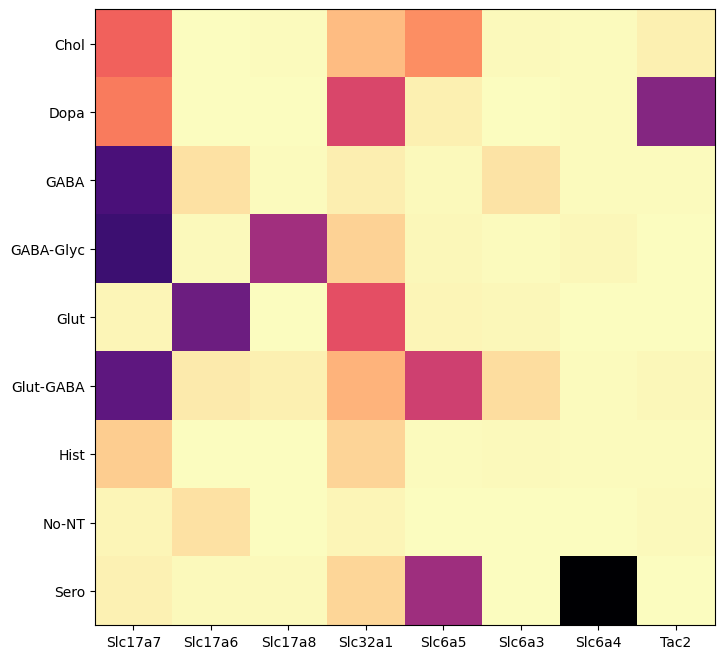

In [10]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'neurotransmitter_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

By dissection region of interest shows that each of these genes are associated with distinct regions. 

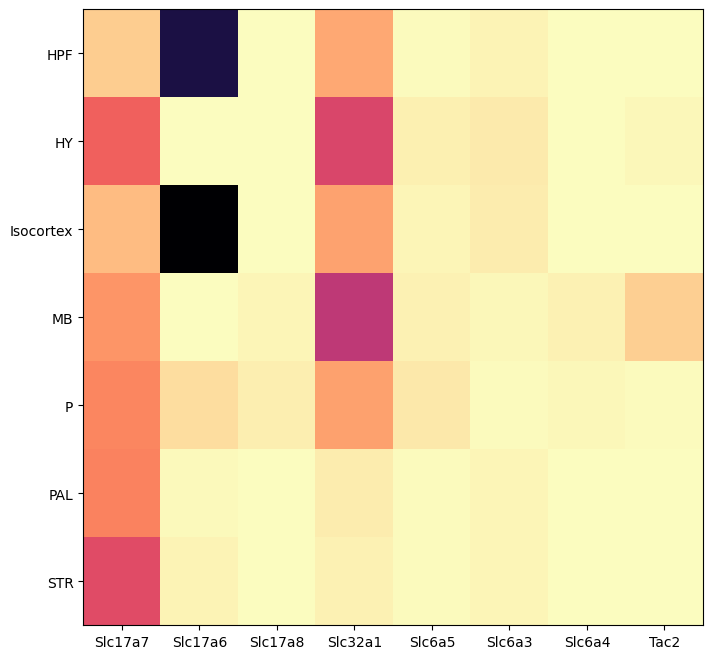

In [11]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'anatomical_division_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

And finally, by class from the taxonomy. 

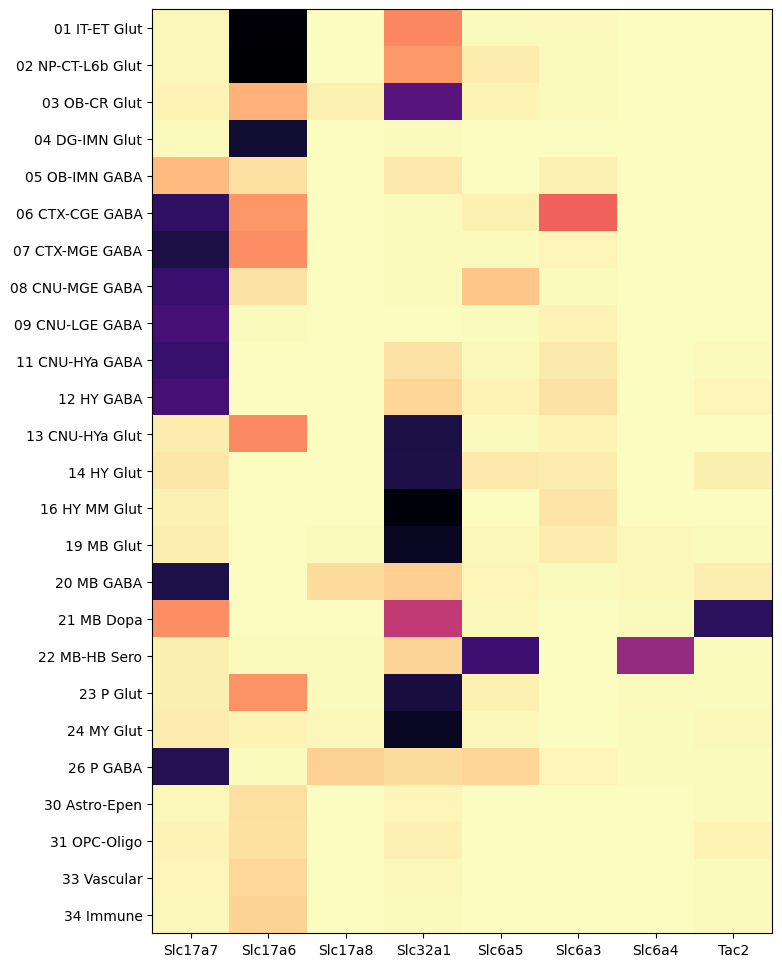

In [12]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'class_name')
res = plot_heatmap(agg, 8, 12)
plt.show()

We can also visualize the relationship between these genes and their location in the UMAP. Note again as in part one that Neurons and Non-neurons should be plotted separately. 

In [13]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

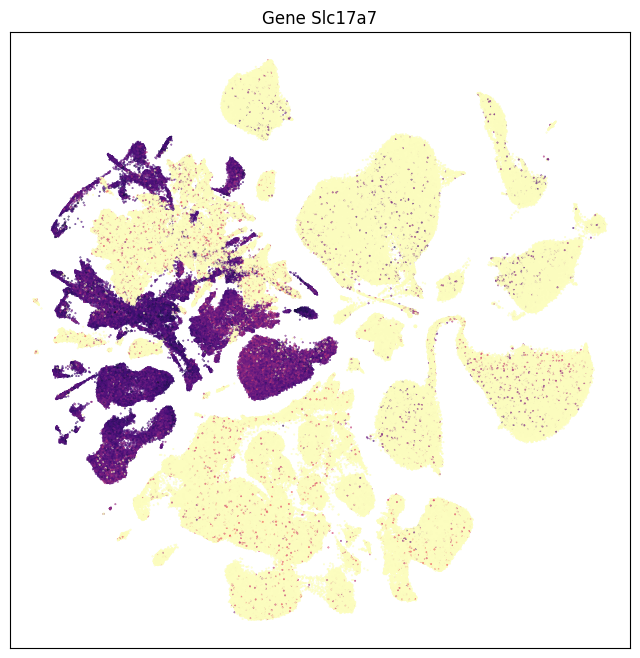

In [14]:
for gene_name in glist:
    fig, ax = plot_umap(
        cell_extended_with_genes['x'],
        cell_extended_with_genes['y'],
        val=cell_extended_with_genes[gene_name],
        cmap=plt.cm.magma_r)
    res = ax.set_title(f"Gene {gene_name}")
    plt.show()
    break

## AgeDE Genes 

The Aging Mouse data also provides a set of aging Differential Expression (ageDE) genes at various levels of the taxonomy. The table is presented as a flattened set of ageDE genes found within a specific cell type where each row is a unique gene/celltype combination. Note that for a given level in the taxonomy, only certain cell types have significant ageDE genes reported. For instance, the supertype level in the aging_degenes table only contains non-neuronal cell types. 

Below we load and display this table. 

In [114]:
degenes = pd.read_csv(taxonomy_base / 'aging_degenes.csv' )
degenes.head()

,grouping_type,grouping_label,grouping_name,gene_identifier,gene_symbol,is_primary_ieg,age_effect_size,unadjusted_pvalue,adjusted_pvalue,confidence_interval_higher_bound,confidence_interval_lower_bound
0,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000073590,3222401L13Rik,False,1.812935,7.766049e-12,9.653199e-08,2.346020,1.279850
1,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000095041,AC149090.1,False,1.289552,3.322308e-17,4.129629e-13,1.793447,0.785656
2,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000086503,Xist,False,1.185049,2.222176e-11,2.762165e-07,1.645855,0.724244
3,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000073590,3222401L13Rik,False,1.867499,1.532389e-15,1.963297e-11,2.366093,1.368905
4,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000095041,AC149090.1,False,1.229435,4.989205e-25,6.392170e-21,1.589657,0.869213


Additionally, we load a mapping of all clusters to the levels higher in the taxonomy complete with their colors.

In [88]:
mapping = pd.read_csv(taxonomy_base / 'cluster_mapping_pivot.csv' )
mapping

,cluster_alias,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color
0,1,CS20241021_0001,0,1_CLA-EPd-CTX Car3 Glut_1,#f7c27a,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,#FA0087,#64c2fc,#99822E
1,2,CS20241021_0002,1,2_IT EP-CLA Glut_1,#5c1a34,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
2,3,CS20241021_0003,2,3_IT EP-CLA Glut_1,#b96cf0,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
3,4,CS20241021_0004,3,4_IT EP-CLA Glut_1,#bff691,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
4,5,CS20241021_0005,4,5_IT EP-CLA Glut_1,#39fbfa,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
...,...,...,...,...,...,...,...,...,...,...,...
842,843,CS20241021_0843,842,843_Microglia NN_1,#a88b30,34 Immune,334 Microglia NN,1194 Microglia NN_1,#825f45,#CC1F4E,#62CC3D
843,844,CS20241021_0844,843,844_Microglia NN_1,#df92c3,34 Immune,334 Microglia NN,1194 Microglia NN_1,#825f45,#CC1F4E,#62CC3D
844,845,CS20241021_0845,844,845_BAM NN_1,#a1adea,34 Immune,335 BAM NN,1195 BAM NN_1,#825f45,#66493D,#32662E
845,846,CS20241021_0846,845,846_DC NN_1,#9a5824,34 Immune,337 DC NN,1197 DC NN_1,#825f45,#CCA27A,#FF999F


## ageDE vs supertype/subclass/cluster 

We declare a convenience function for working with our two tables above. This calculates the number of ageDE genes for a selected level in the taxonomy (cluster, supertype, subclass) and plots them as a bar graph. 

In [118]:
def plot_de_gene_count_by_taxonomy(
        mapping_df: pd.DataFrame,
        degene_df: pd.DataFrame,
        level_name: str,
        color_name: str,
        title: Optional[str]=None,
        max_n_bars: int=None,
        xlim: Tuple[int, int]=(0, 400),
        figsize: Tuple[int, int]=(3.5, 8)
) -> pd.DataFrame:
    """Plot ageDE genes grouped by cluser, supertype, subclass.

    Parameters
    ----------
    mapping_df: pandas.DataFrame
        DataFrame mapping of cluster to higher taxonomy levels with colors.
    degene_df: pandas.DataFrame
        DataFrame of ageDE genes with their associated cell type.
    level_name: str
        Name of taxonomy level to plot.
    """
    # Get our colors
    color_map = mapping_df[[level_name, color_name]].copy()
    color_map.drop_duplicates(inplace=True)
    color_map.set_index(level_name, inplace=True)

    # Get counts for level (e.g. supertype_name)
    grouped = degene_df.groupby(['grouping_type', 'grouping_name'])['gene_symbol'].count()[level_name.split('_')[0]]

    # Setup our figure
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(figsize[0], figsize[1])

    # Get the values to plot, reversing their order.
    if max_n_bars is None:
        max_n_bars = len(grouped)
    counts = grouped.values[::-1][-max_n_bars:]
    names = grouped.index.values[::-1][-max_n_bars:]
    colors = color_map.loc[names, color_name].values[-max_n_bars:]

    # plot
    ax.barh(names, counts, color=colors)
    ax.set_xlim([xlim[0], xlim[1]])
    ax.set_ylim([0, max_n_bars])
    ax.set_title(title)
    plt.show()

### vs Non-neuronal supertype

We'll use groupby over supertype to plot the non-neuronal ageDE genes. 

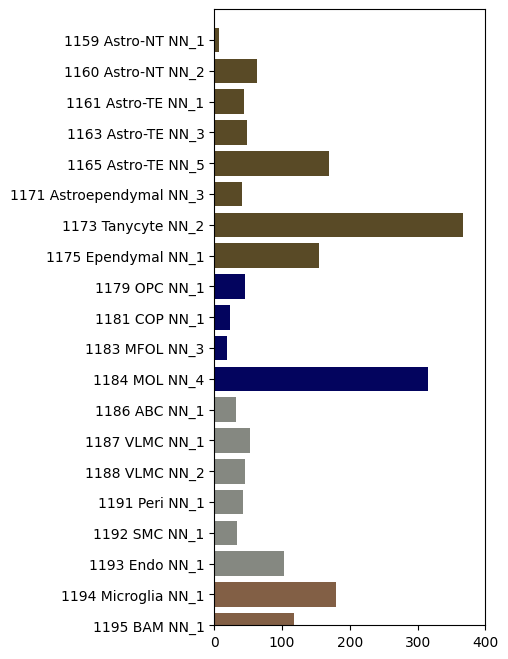

In [57]:
plot_de_gene_count_by_taxonomy(mapping, degenes, 'supertype_name', 'class_color')

### vs Neuronal subclasses 

And now the same but this time for the first two of the neuronal subclasses. Remove `max_n_bars` from the function call below to plot all subclasses. 

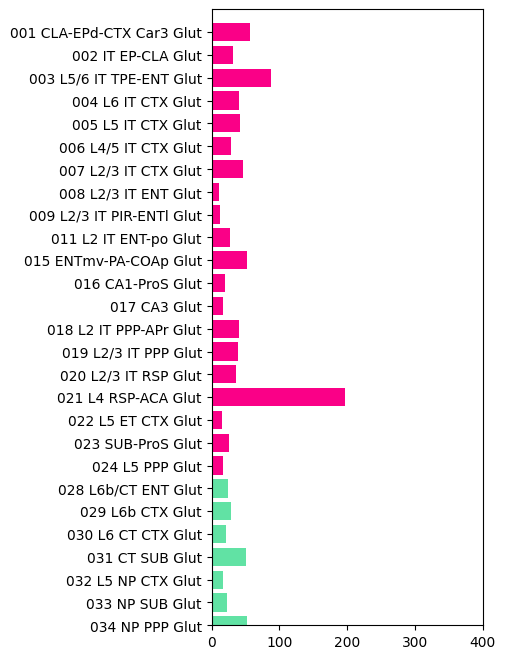

In [112]:
plot_de_gene_count_by_taxonomy(
    mapping,
    degenes,
    'subclass_name',
    'class_color',
    figsize=(3.5, 8),
    max_n_bars=27
)

### vs Neuronal clusters

And now the same but this time for the neuronal clusters. Here we plot only one class worth worth of clusters. Removing `max_n_bars` for below will show all clusters over both neuronal clusters in the DataFrame.

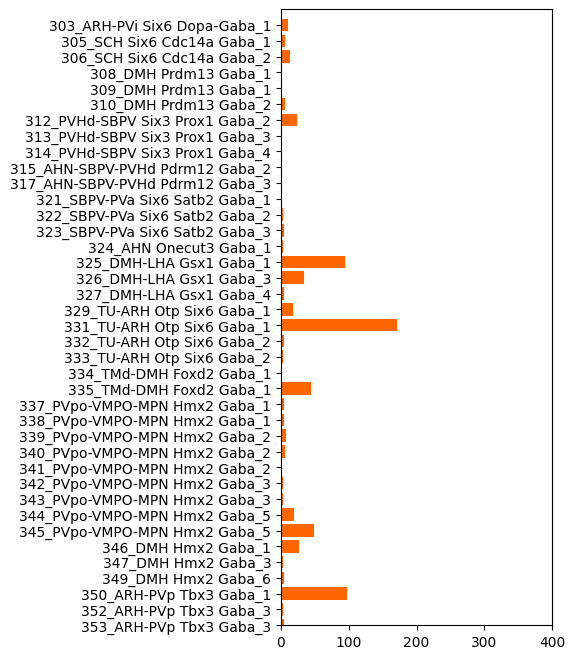

In [126]:
plot_de_gene_count_by_taxonomy(
    mapping,
    degenes,
    'cluster_name',
    'class_color',
    figsize=(3.5, 8),
    max_n_bars=39
)

### Select ageDE expression vs subclass 

Finally, we'll plot the expression of a select set of ageDE genes vs the subclasses in the taxonomy. These genes are a subset of the those plotted in [FIGURE] from Zeng et al. Note also that the ordering of the subclasses is different that the ordering in that plot. 

Red in the below plot represents a decrease in expression with age while blue and increase. 

In [21]:
degene_list = ['3222401L13Rik', 'Slc5a5', 'AC149090.1', 'Ccnd1', 'Ccnd2']
subclass_degenes = degenes[degenes['grouping_type'] == 'subclass']
subclasses = sorted(subclass_degenes['grouping_name'].unique())
subclass_by_gene = pd.DataFrame(columns=degene_list, index=subclasses)
for idx, derow in subclass_degenes.iterrows():
    if derow['gene_symbol'] in degene_list:
        subclass_by_gene.loc[derow['grouping_name'], derow['gene_symbol']] = derow['age_effect_size']
subclass_by_gene.head()

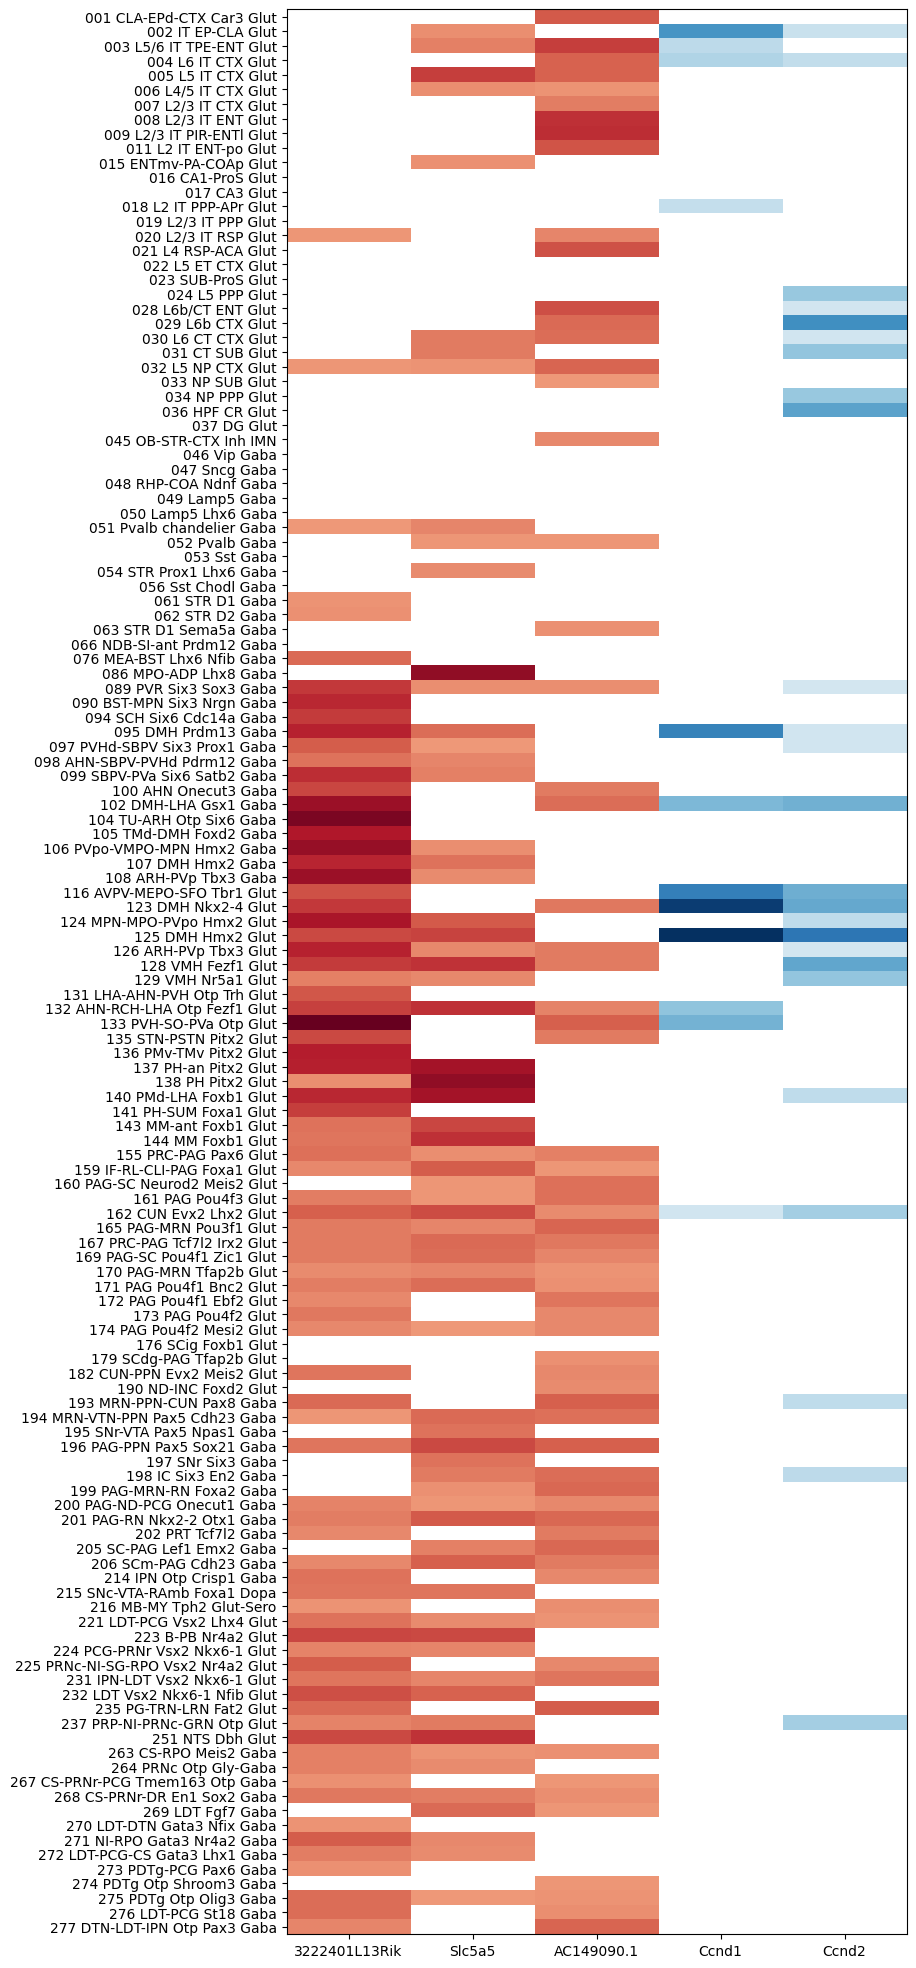

In [33]:
res = plot_heatmap(subclass_by_gene, 8, 25, cmap=plt.cm.RdBu_r, vmin=-4, vmax=4)
plt.show()